# Pytorch paper replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

## Get Setup

In [1]:
import torch as pt
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torch import nn
import helper_functions
from torchvision import transforms

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Get data

We already have our data imported so we just need to divide our data for train/ test datasets

In [2]:
from pathlib import Path
# setup directories paths to trian and test images
train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/test')

In [3]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

## Create Datasets and Dataloaders

In [4]:
from going_modular import data_setup

# Create an image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
# Create a batch size of 32
BATCH_SIZE = 32

# Create DataLoader
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloaders))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# veiw the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

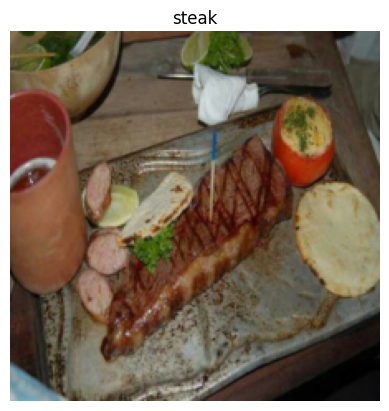

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Replicating ViT: overview

## Split data into patches and creating a class, position and patch embadding

layers=>input=>function=>output

In [8]:
height =224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches 
number_of_pathces = int((height * width) / patch_size**2)
number_of_pathces

196

In [9]:
embedding_layer = (height, width, color_channels)

embedding_layer_output_shape = (number_of_pathces, patch_size**2 * color_channels)

print(f'input shape (single 2D image): {embedding_layer}')
print(f'output shape (1D sequence of images): {embedding_layer_output_shape}')

input shape (single 2D image): (224, 224, 3)
output shape (1D sequence of images): (196, 768)


## Turning a single image into pathces

In [10]:
image.shape

torch.Size([3, 224, 224])

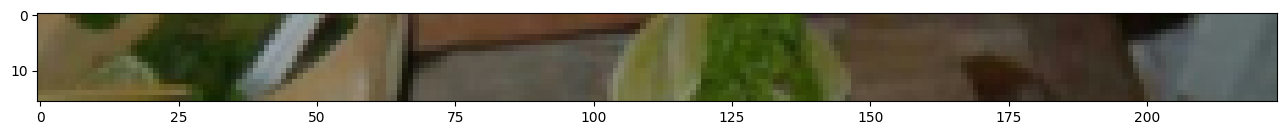

In [11]:
image_permuted = image.permute(1,2,0)

# index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


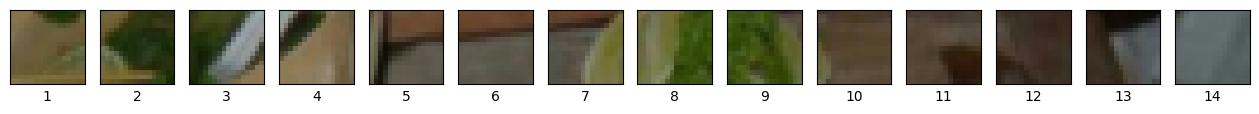

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisable by patch size'
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of pathces in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

number of pathes per row: 14.0
Number of patches per column: 14.0
Total pathces: 196.0
Patch size: 16 pixels x 16 pixels


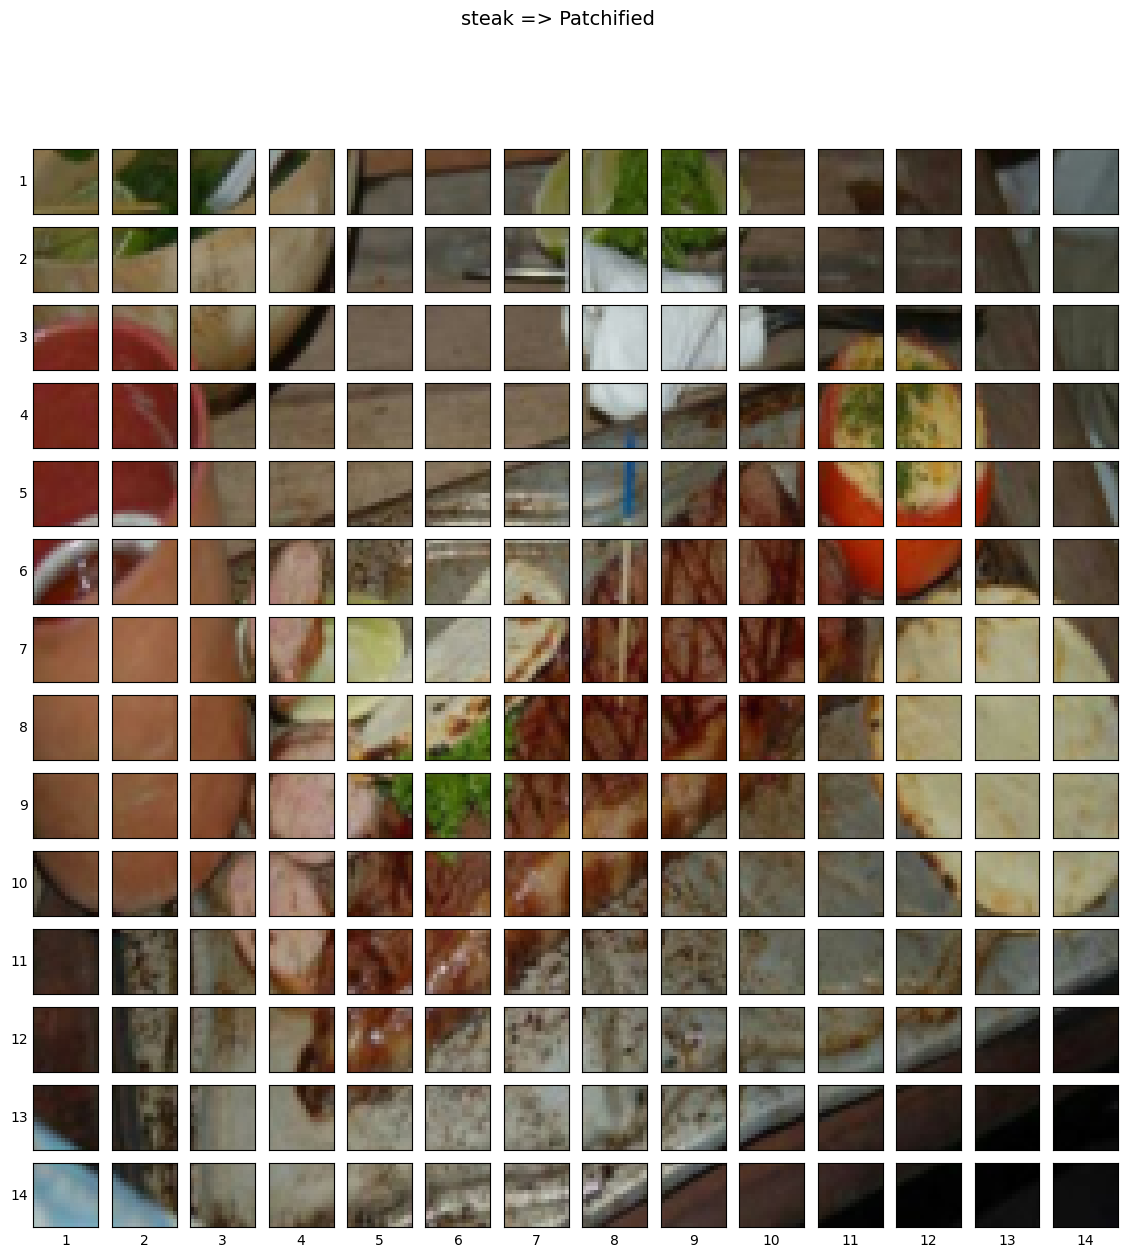

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'image size must be divisable by patch size'
print(f'number of pathes per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal pathces: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a seriese of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0,img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                        patch_width:patch_width+patch_size,
                        :])
        # Set up label info for each subplot
        axs[i,j].set_ylabel(i+1,
                            rotation='horizontal',
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f'{class_names[label]} => Patchified', fontsize=14)
plt.show()

## Creating image patches and turning them into patch embaddings

In [14]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

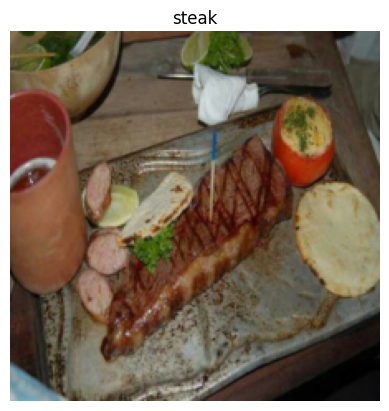

In [15]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [17]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [442, 417, 676, 2, 45]


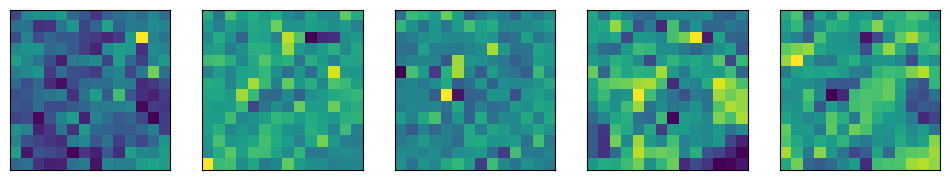

In [18]:
# plot random convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f'showing random convolutional feature maps from indexes: {random_indexes}')

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :,:]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
single_image_map = image_out_of_conv[:,0,:,:]
single_image_map, single_image_map.requires_grad

(tensor([[[ 0.2807,  0.2084,  0.2467,  0.2940,  0.2485,  0.1800,  0.1884,
            0.2163,  0.1339,  0.1979,  0.2121,  0.1490,  0.1724,  0.3254],
          [ 0.2157,  0.1855,  0.2150,  0.3808,  0.1211,  0.2860,  0.2027,
            0.4818,  0.3461,  0.1580,  0.1898,  0.1728,  0.1636,  0.1935],
          [ 0.2332,  0.2480,  0.2820,  0.2541,  0.2697,  0.2725,  0.2784,
            0.5802,  0.6007,  0.4723,  0.1031,  0.1092,  0.1228,  0.1858],
          [ 0.1221,  0.1290,  0.1728,  0.1543,  0.2497,  0.2768,  0.2858,
            0.4438,  0.3858,  0.1268,  0.1073,  0.0784,  0.2585,  0.2004],
          [ 0.1251,  0.2993,  0.2349,  0.2649,  0.2435,  0.2914,  0.3756,
            0.4478,  0.1931,  0.2198,  0.0223,  0.1598,  0.3049,  0.2001],
          [ 0.1675,  0.1832,  0.2646,  0.2740,  0.2253,  0.2677,  0.3108,
            0.2830,  0.1232,  0.1944, -0.0011,  0.0883,  0.1941,  0.2050],
          [ 0.1741,  0.2719,  0.2917,  0.2606,  0.4184,  0.3831,  0.4981,
            0.1864,  0.0521,  0.

## Flattening patch embaddings

In [20]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

original image shape: torch.Size([3, 224, 224])
Image feature map (pathces) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: tensor([[[ 0.2807,  0.2084,  0.2467,  ...,  0.0529,  0.0199,  0.0436],
         [ 0.1655,  0.1599,  0.2082,  ...,  0.0389,  0.0306,  0.0397],
         [ 0.1911,  0.1279,  0.1910,  ...,  0.0117,  0.0158,  0.0320],
         ...,
         [ 0.2207,  0.1729,  0.4367,  ...,  0.0089,  0.0044,  0.0251],
         [-0.0336, -0.0342, -0.0090,  ..., -0.0273,  0.0220,  0.0042],
         [ 0.0015, -0.0349, -0.1926,  ..., -0.0158, -0.0109, -0.0039]]],
       grad_fn=<ViewBackward0>)


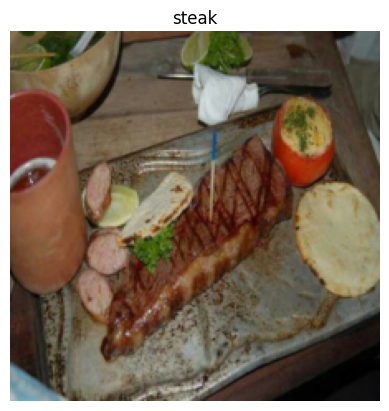

In [21]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (pathces) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened}')

In [22]:
# rearrange output of flatten layer
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape}')

torch.Size([1, 196, 768])


In [23]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)

In [24]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

tensor([[ 0.2807,  0.2084,  0.2467,  0.2940,  0.2485,  0.1800,  0.1884,  0.2163,
          0.1339,  0.1979,  0.2121,  0.1490,  0.1724,  0.3254,  0.2157,  0.1855,
          0.2150,  0.3808,  0.1211,  0.2860,  0.2027,  0.4818,  0.3461,  0.1580,
          0.1898,  0.1728,  0.1636,  0.1935,  0.2332,  0.2480,  0.2820,  0.2541,
          0.2697,  0.2725,  0.2784,  0.5802,  0.6007,  0.4723,  0.1031,  0.1092,
          0.1228,  0.1858,  0.1221,  0.1290,  0.1728,  0.1543,  0.2497,  0.2768,
          0.2858,  0.4438,  0.3858,  0.1268,  0.1073,  0.0784,  0.2585,  0.2004,
          0.1251,  0.2993,  0.2349,  0.2649,  0.2435,  0.2914,  0.3756,  0.4478,
          0.1931,  0.2198,  0.0223,  0.1598,  0.3049,  0.2001,  0.1675,  0.1832,
          0.2646,  0.2740,  0.2253,  0.2677,  0.3108,  0.2830,  0.1232,  0.1944,
         -0.0011,  0.0883,  0.1941,  0.2050,  0.1741,  0.2719,  0.2917,  0.2606,
          0.4184,  0.3831,  0.4981,  0.1864,  0.0521,  0.0911,  0.1028,  0.2412,
          0.3954,  0.4802,  

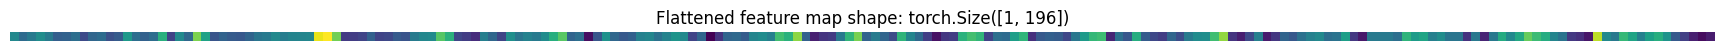

In [25]:
# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);

## Turning the ViT patch embedding layer into a PyTorch module

In [28]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'Input image size must be divisable by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

In [29]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [30]:
rand_image_tensor = pt.randn(1,3,224,224)
rand_image_tensor_bad = pt.randn(1,3,250,250)

## Creating a class token embedding

In [31]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [32]:
# Get the batch size and the embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
# Create class token embedding as a learnable parameter that shares the same size as the 
class_token = nn.Parameter(pt.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [34]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [35]:
patch_embedded_image_with_class_embedding = pt.cat((class_token, patch_embedded_image),
                                                   dim=1)

print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} => (batch_size, class_token + number_of_patches, embedding_dimension)')

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 5.3908e-03, -7.9716e-04, -3.3115e-01,  ..., -3.6995e-01,
           1.1957e-01,  5.0845e-02],
         [ 2.9918e-02, -6.1294e-02, -2.1573e-01,  ..., -2.3770e-01,
           5.6094e-02,  4.2619e-02],
         ...,
         [-4.1860e-04,  1.3432e-02, -3.0880e-02,  ...,  4.2523e-03,
          -3.2920e-02, -1.7185e-02],
         [ 1.2675e-02, -1.5729e-02, -9.4698e-03,  ..., -4.9527e-03,
           8.5022e-03, -1.1851e-02],
         [ 9.0051e-03, -4.0988e-03, -1.0439e-02,  ..., -1.2543e-02,
          -1.6841e-03, -9.1814e-03]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) => (batch_size, class_token + number_of_patches, embedding_dimension)


In [36]:
patchify(rand_image_tensor)

tensor([[[-0.5099, -0.6634,  0.8431,  ...,  0.0676, -0.2643, -1.1853],
         [ 0.0428,  0.5109,  0.2519,  ...,  0.3897,  0.1461, -0.0667],
         [ 0.8504, -0.7369, -0.3490,  ...,  0.5712,  0.0359,  0.3665],
         ...,
         [-0.3092,  0.5286, -0.7041,  ...,  0.5127,  0.1570,  0.1817],
         [ 0.4227, -0.2082, -0.1987,  ..., -0.8052,  0.3465,  0.1599],
         [-0.5692,  0.4996, -0.1676,  ...,  0.2897, -0.0388,  1.1215]]],
       grad_fn=<PermuteBackward0>)

## Creating position embedding

In [37]:
# View the seqience of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 5.3908e-03, -7.9716e-04, -3.3115e-01,  ..., -3.6995e-01,
            1.1957e-01,  5.0845e-02],
          [ 2.9918e-02, -6.1294e-02, -2.1573e-01,  ..., -2.3770e-01,
            5.6094e-02,  4.2619e-02],
          ...,
          [-4.1860e-04,  1.3432e-02, -3.0880e-02,  ...,  4.2523e-03,
           -3.2920e-02, -1.7185e-02],
          [ 1.2675e-02, -1.5729e-02, -9.4698e-03,  ..., -4.9527e-03,
            8.5022e-03, -1.1851e-02],
          [ 9.0051e-03, -4.0988e-03, -1.0439e-02,  ..., -1.2543e-02,
           -1.6841e-03, -9.1814e-03]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [39]:
# Calculate N value 
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(pt.ones(1,
                                          number_of_patches+1,
                                          embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [40]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0054, 0.9992, 0.6689,  ..., 0.6300, 1.1196, 1.0508],
         [1.0299, 0.9387, 0.7843,  ..., 0.7623, 1.0561, 1.0426],
         ...,
         [0.9996, 1.0134, 0.9691,  ..., 1.0043, 0.9671, 0.9828],
         [1.0127, 0.9843, 0.9905,  ..., 0.9950, 1.0085, 0.9881],
         [1.0090, 0.9959, 0.9896,  ..., 0.9875, 0.9983, 0.9908]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


## Putting it all together

In [42]:
patch_size = 16

print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

patch_embedded_layer = PatchEmbedding(in_channels=3,
                                      patch_size=patch_size,
                                      embedding_dim=768)

patch_embedding = patch_embedded_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(pt.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # makes sure it's learnable
print(f'Class token embedding shape: {class_token.shape}')

patch_embedding_class_token = pt.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(pt.ones(1, number_of_pathces+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## MultiHead self-Attention (MSA) Block

In [45]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # Create multihead attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [46]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## Multilayer Perception (MLP block)

In [49]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):
        
        super().__init__()

        #Create the norm layer(LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [50]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input of MLP block: {patched_image_through_mlp_block.shape}')
print(f'Output of MSA block: {patched_image_through_msa_block.shape}')

Input of MLP block: torch.Size([1, 197, 768])
Output of MSA block: torch.Size([1, 197, 768])


## Creating the Transformer encoder

In [51]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size=3072,
                 mlp_dropout:int=0.1,
                 attn_dropout:int=0):
        super().__init__()

        # Create MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [58]:
from torchinfo import summary
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Create a custom Transformer Encoder block

In [60]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [61]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Creating ViT

In [67]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=pt.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=pt.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = pt.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [68]:
# Create a random tensor with same shape as a single image
random_image_tensor = pt.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.0467,  0.4735,  0.4480]], grad_fn=<AddmmBackward0>)

In [69]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Setting up training code for custom ViT

In [76]:
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = pt.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = pt.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloaders,
                       test_dataloader=test_dataloaders,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4900 | train_acc: 0.3125 | test_loss: 4.8573 | test_acc: 0.1979
Epoch: 2 | train_loss: 2.3854 | train_acc: 0.2930 | test_loss: 2.9295 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4084 | train_acc: 0.3008 | test_loss: 1.1858 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1860 | train_acc: 0.2656 | test_loss: 1.0502 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1796 | train_acc: 0.2578 | test_loss: 1.0072 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1505 | train_acc: 0.3555 | test_loss: 1.0053 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1904 | train_acc: 0.2656 | test_loss: 1.0432 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1292 | train_acc: 0.4062 | test_loss: 1.2826 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.2232 | train_acc: 0.2969 | test_loss: 1.0283 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2306 | train_acc: 0.2812 | test_loss: 1.2898 | test_acc: 0.1979


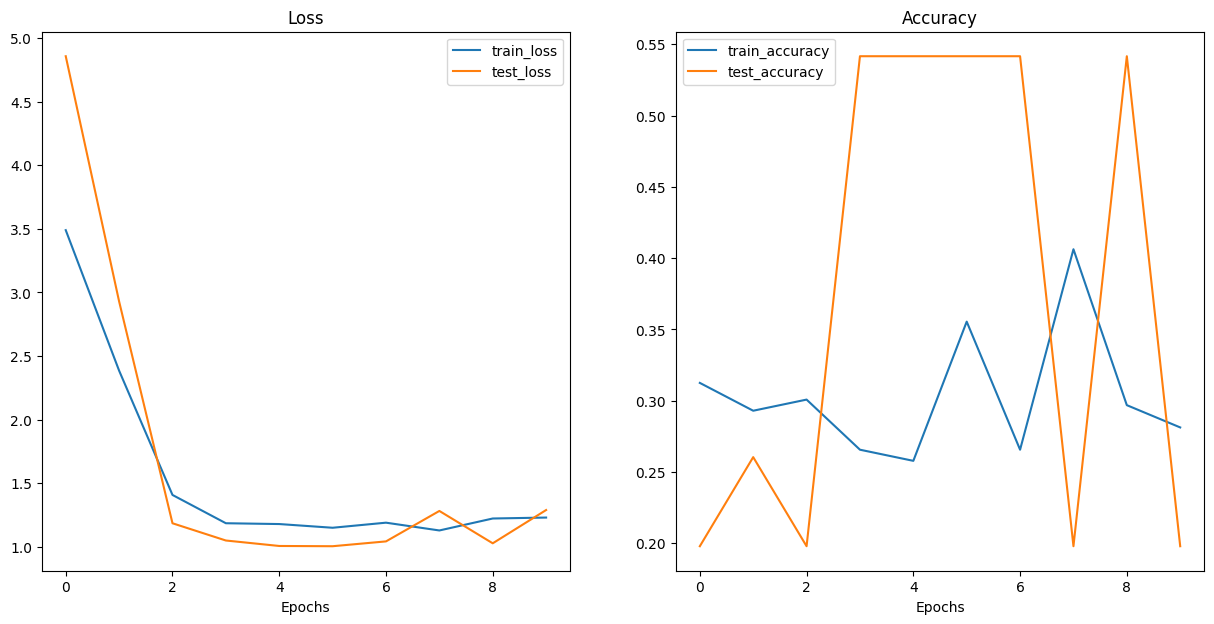

In [77]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## Using a Pretrained Vision Transformer from TorchVision

In [79]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))
pretrained_vit 

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [81]:
# Print a summary using torchinfo 
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Preparing Data 

In [82]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="food_img")
image_path

[INFO] Did not find data\food_img directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


WindowsPath('data/food_img')

In [83]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/food_img/train'), WindowsPath('data/food_img/test'))

In [84]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [85]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [87]:
from going_modular import engine

# Create optimizer and loss function
optimizer = pt.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = pt.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8393 | train_acc: 0.7227 | test_loss: 0.5372 | test_acc: 0.8163
Epoch: 2 | train_loss: 0.4023 | train_acc: 0.9258 | test_loss: 0.4175 | test_acc: 0.7964
Epoch: 3 | train_loss: 0.2315 | train_acc: 0.9375 | test_loss: 0.3434 | test_acc: 0.8674
Epoch: 4 | train_loss: 0.1891 | train_acc: 0.9648 | test_loss: 0.2715 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1612 | train_acc: 0.9648 | test_loss: 0.2471 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.1240 | train_acc: 0.9648 | test_loss: 0.2371 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.1083 | train_acc: 0.9688 | test_loss: 0.2284 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.1685 | train_acc: 0.9727 | test_loss: 0.2180 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.1856 | train_acc: 0.8555 | test_loss: 0.1960 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0862 | train_acc: 0.9883 | test_loss: 0.2236 | test_acc: 0.8873


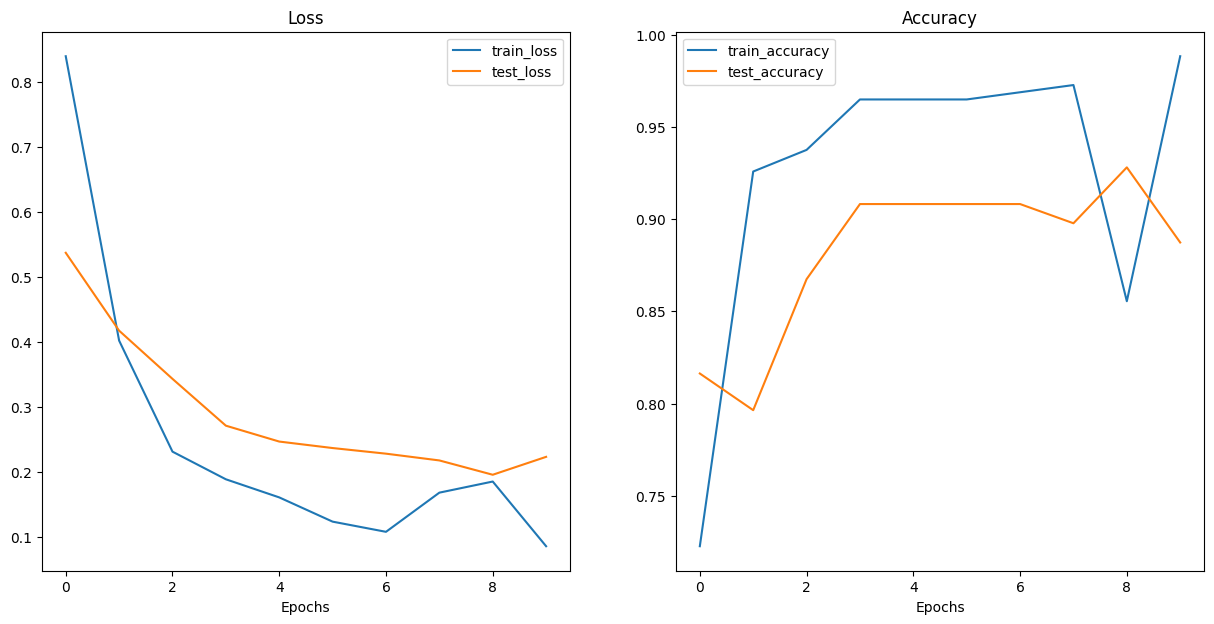

In [88]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [90]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_food_vision.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor_food_vision.pth


In [91]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_food_vision.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
